In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load the dataset
# -------------------------------
datafile = "C:/Users/Dila Ozberkman/Desktop/AMS Research/Urban Shade/Data/gertjandatafiets.csv"
df = pd.read_csv(datafile)

# -------------------------------
# 2. Inspect the dataset columns
# -------------------------------
print("Columns in the dataset:")
print(df.columns.tolist())

# -------------------------------
# 3. Check for required columns
# -------------------------------
# For calculating MRT we need:
# - Air_Temp: sensor (or air) temperature in °C (to correct long-wave measurements)
# - Short-wave measurements: Qs_in, Qs_out, Qs_left, Qs_right, Qs_front, Qs_back
# - Long-wave measurements: QL_in, QL_out, QL_left, QL_right, QL_front, QL_back

required_cols = ['Air_Temp',
                 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back',
                 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back']

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError("The following required columns are missing from the dataset: " + str(missing_cols))

# -------------------------------
# 4. Set constants and parameters
# -------------------------------
# Stefan-Boltzmann constant in W/m^2/K^4
sigma = 5.67e-8

# Absorptivity factor for short-wave radiation (commonly ~0.7 for human skin/clothing)
absorptivity = 0.7

# -------------------------------
# 5. Prepare the data for MRT calculation
# -------------------------------
# Convert sensor (air) temperature from °C to Kelvin.
df['T_sensor_K'] = df['Air_Temp'] + 273.15

# Compute the blackbody emission term at the sensor temperature.
# According to the emails, the correction for long-wave radiation is:
#    correction = sigma * T_sensor_K^4
df['L_corr_term'] = sigma * (df['T_sensor_K'] ** 4)

# Define the six directions that are measured.
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# For each direction, combine the shortwave and longwave components.
# The effective radiative flux for a given direction is:
#   E_dir = (QL_dir + L_corr_term) + absorptivity * Qs_dir
# where QL_dir is the raw longwave measurement (which may be negative),
# L_corr_term is the blackbody correction,
# and Qs_dir is the short-wave measurement.
for d in directions:
    Qs_col = 'Qs_' + d
    QL_col = 'QL_' + d
    eff_col = 'E_' + d  # effective flux from this direction

    df[eff_col] = (df[QL_col] + df['L_corr_term']) + absorptivity * df[Qs_col]

# Compute the average effective radiative flux from the six directions.
eff_cols = ['E_' + d for d in directions]
df['E_avg'] = df[eff_cols].mean(axis=1)

# -------------------------------
# 6. Calculate Mean Radiant Temperature (MRT)
# -------------------------------
# Using the Stefan-Boltzmann law:
#   sigma * MRT^4 = E_avg   =>   MRT = (E_avg / sigma)^(1/4)
df['MRT_K'] = (df['E_avg'] / sigma) ** 0.25

# Convert MRT to °C if desired:
df['MRT_C'] = df['MRT_K'] - 273.15

# -------------------------------
# 7. Display and (optionally) save the results
# -------------------------------
# Show the first few rows with key columns.
print("\nFirst few rows with MRT values (in Kelvin and °C):")
print(df[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

# # (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
# df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Columns in the dataset:
['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude']

First few rows with MRT values (in Kelvin and °C):
         TIMESTAMP  Air_Temp       MRT_K      MRT_C
0  8/23/2023 12:57     25.33  298.723749  25.573749
1  8/23/2023 12:57     25.29  298.737445  25.587445
2  8/23/2023 12:57     25.29  298.770103  25.620103
3  8/23/2023 12:57     25.22  298.703257  25.553257
4  8/23/2023 12:57     25.13  298.613531  25.463531


In [3]:
# Assuming the following have been defined earlier:
# - df: your DataFrame loaded from 'gertjandatafiets.csv'
# - sigma: the Stefan-Boltzmann constant (5.67e-8 W/m²/K⁴)
# - absorptivity: the absorptivity factor for short-wave radiation (e.g., 0.7)
# - 'T_sensor_K' column exists (Air_Temp in Kelvin)
# - 'L_corr_term' has been computed as sigma * (T_sensor_K)**4

# Define the six directions:
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# Compute disaggregated effective radiative flux components for each direction.
for d in directions:
    Qs_col = 'Qs_' + d   # Shortwave measurement, e.g., Qs_in
    QL_col = 'QL_' + d   # Longwave measurement, e.g., QL_in

    # Compute the effective longwave component (W/m²):
    # Correct the raw longwave reading using the sensor temperature correction term.
    df['E_long_' + d] = df[QL_col] + df['L_corr_term']

    # Compute the effective shortwave component (W/m²):
    # Scale the shortwave measurement by the absorptivity factor.
    df['E_short_' + d] = absorptivity * df[Qs_col]

    # Optionally, compute the total effective flux (which is the sum of both components)
    df['E_total_' + d] = df['E_long_' + d] + df['E_short_' + d]

# Display a few rows of the new disaggregated columns
cols_to_show = ['TIMESTAMP'] + \
               ['E_long_' + d for d in directions] + \
               ['E_short_' + d for d in directions] + \
               ['E_total_' + d for d in directions]
print("Disaggregated effective flux values (W/m²) for each direction:")
df[cols_to_show].head()
# (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
# df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Disaggregated effective flux values (W/m²) for each direction:


,TIMESTAMP,E_long_in,E_long_out,E_long_left,E_long_right,E_long_front,E_long_back,E_short_in,E_short_out,E_short_left,E_short_right,E_short_front,E_short_back,E_total_in,E_total_out,E_total_left,E_total_right,E_total_front,E_total_back
0,8/23/2023 12:57,429.602629,439.032629,443.468629,447.499629,440.492629,438.522629,27.090,1.5701,10.465,5.768,13.832,11.683,456.692629,440.602729,453.933629,453.267629,454.324629,450.205629
1,8/23/2023 12:57,429.361438,438.791438,443.227438,447.373438,440.251438,440.691438,27.090,1.5701,10.619,5.768,13.832,10.948,456.451438,440.361538,453.846438,453.141438,454.083438,451.639438
2,8/23/2023 12:57,429.361438,438.901438,443.227438,447.373438,440.251438,443.369438,27.090,1.5701,10.619,5.768,13.832,9.345,456.451438,440.471538,453.846438,453.141438,454.083438,452.714438
3,8/23/2023 12:57,428.939587,438.479587,442.805587,446.951587,439.829587,441.877587,27.244,1.5701,10.619,5.768,13.832,10.367,456.183587,440.049687,453.424587,452.719587,453.661587,452.244587
4,8/23/2023 12:57,428.397643,438.047643,442.263643,446.525643,439.287643,440.667643,27.244,1.5701,10.619,5.768,13.832,10.808,455.641643,439.617743,452.882643,452.293643,453.119643,451.475643


Summary statistics for MRT (Kelvin):
count    33968.000000
mean       305.240072
std          8.630832
min        293.185539
25%        299.020377
50%        302.446884
75%        308.371356
max        339.820191
Name: MRT_K, dtype: float64

Summary statistics for MRT (°C):
count    33968.000000
mean        32.090072
std          8.630832
min         20.035539
25%         25.870377
50%         29.296884
75%         35.221356
max         66.670191
Name: MRT_C, dtype: float64


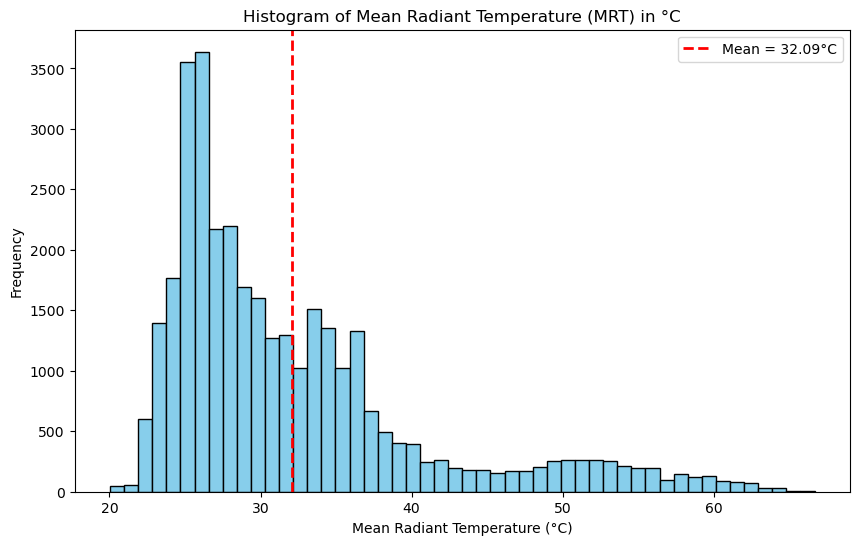

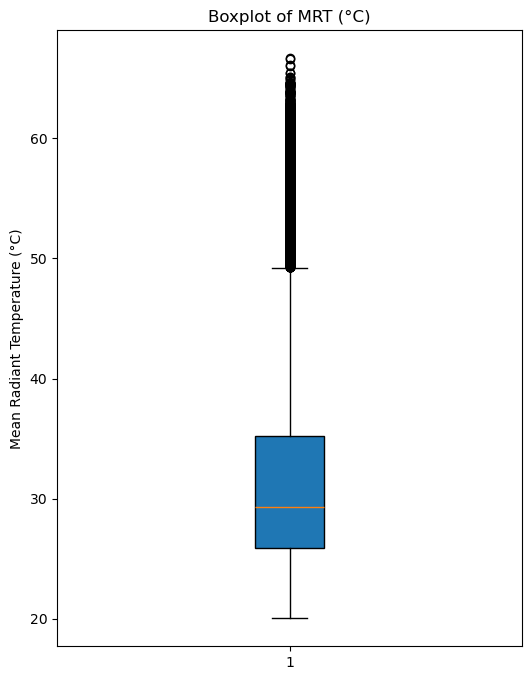

Number of MRT values below 15°C: 0
Number of MRT values above 60°C: 320

Rows with MRT values outside the expected range:
            TIMESTAMP  Air_Temp       MRT_K      MRT_C
1027  8/23/2023 13:14     24.65  333.361431  60.211431
1028  8/23/2023 13:14     24.75  333.915833  60.765833
1029  8/23/2023 13:14     24.77  334.221810  61.071810
1030  8/23/2023 13:14     24.79  333.835162  60.685162
1031  8/23/2023 13:14     24.81  333.357481  60.207481


In [4]:
import matplotlib.pyplot as plt

# -------------------------------
# 1. Summary Statistics
# -------------------------------
print("Summary statistics for MRT (Kelvin):")
print(df['MRT_K'].describe())

print("\nSummary statistics for MRT (°C):")
print(df['MRT_C'].describe())

# -------------------------------
# 2. Histogram of MRT (in °C)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.hist(df['MRT_C'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel("Mean Radiant Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Radiant Temperature (MRT) in °C")
# Draw a vertical line at the mean value
mean_mrt = df['MRT_C'].mean()
plt.axvline(mean_mrt, color='red', linestyle='dashed', linewidth=2,
            label=f"Mean = {mean_mrt:.2f}°C")
plt.legend()
plt.show()

# -------------------------------
# 3. Boxplot of MRT (in °C)
# -------------------------------
plt.figure(figsize=(6, 8))
plt.boxplot(df['MRT_C'].dropna(), patch_artist=True, vert=True)
plt.ylabel("Mean Radiant Temperature (°C)")
plt.title("Boxplot of MRT (°C)")
plt.show()

# -------------------------------
# 4. Identify Out-of-Range MRT Values
# -------------------------------
# Define an expected range for MRT in °C. (Adjust these limits as needed.)
expected_lower = 15
expected_upper = 60

n_below = (df['MRT_C'] < expected_lower).sum()
n_above = (df['MRT_C'] > expected_upper).sum()

print(f"Number of MRT values below {expected_lower}°C: {n_below}")
print(f"Number of MRT values above {expected_upper}°C: {n_above}")

# Optionally, list the rows that are out-of-range for further investigation.
outliers = df[(df['MRT_C'] < expected_lower) | (df['MRT_C'] > expected_upper)]
print("\nRows with MRT values outside the expected range:")
print(outliers[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

In [5]:
df.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right',
       'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back'],
      dtype='object')

#### Merge with Shade values

In [6]:
import geopandas as gpd

In [7]:
df_shade = gpd.read_file("../code/results/output/e6a08fb8/climatebike_shade_results.geojson")

In [8]:
df['RECORD'] = df['RECORD'].astype('int32')
df_shade['RECORD'] = df_shade['RECORD'].astype('int32')

In [9]:
df_shade_MRT = pd.merge(df_shade, df[['RECORD','E_in', 'E_out', 'E_left', 'E_right',
       'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back']],on='RECORD', how='inner')

In [10]:
df_shade_MRT.head()

,TIMESTAMP,RECORD,GPSData,Air_Temp,humidity,Qs_in,Qs_out,Qs_left,Qs_right,Qs_front,...,E_total_left,E_long_right,E_short_right,E_total_right,E_long_front,E_short_front,E_total_front,E_long_back,E_short_back,E_total_back
0,8/23/2023 12:57,56706,230823115735N5222666E00452996G004-00018E0000N0...,25.33,48.43,38.7,2.243,14.95,8.24,19.76,...,453.933629,447.499629,5.768,453.267629,440.492629,13.832,454.324629,438.522629,11.683,450.205629
1,8/23/2023 12:57,56707,230823115736N5222666E00452996G004-00018E0000N0...,25.29,48.43,38.7,2.243,15.17,8.24,19.76,...,453.846438,447.373438,5.768,453.141438,440.251438,13.832,454.083438,440.691438,10.948,451.639438
2,8/23/2023 12:57,56708,230823115737N5222666E00452996G004-00018E0000N0...,25.29,48.46,38.7,2.243,15.17,8.24,19.76,...,453.846438,447.373438,5.768,453.141438,440.251438,13.832,454.083438,443.369438,9.345,452.714438
3,8/23/2023 12:57,56709,230823115738N5222666E00452996G004-00018E0000N0...,25.22,48.45,38.92,2.243,15.17,8.24,19.76,...,453.424587,446.951587,5.768,452.719587,439.829587,13.832,453.661587,441.877587,10.367,452.244587
4,8/23/2023 12:57,56710,230823115739N5222666E00452996G004-00018E0000N0...,25.13,48.38,38.92,2.243,15.17,8.24,19.76,...,452.882643,446.525643,5.768,452.293643,439.287643,13.832,453.119643,440.667643,10.808,451.475643


In [11]:
df_shade_MRT.to_csv('../code/results/output/e6a08fb8/climatebike_shade_mrt.csv')

In [12]:
print("Building shadow at timestamp: ", df_shade_MRT['building_shade'].corr(df_shade_MRT['MRT_C']))
print("Tree+Building shadow at timestamp: ", df_shade_MRT['tree_shade'].corr(df_shade_MRT['MRT_C']))
print("Building shadow fraction: ", df_shade_MRT['bldg_shadow_fraction'].corr(df_shade_MRT['MRT_C']))
print("Tree shadow fraction: ", df_shade_MRT['tree_shadow_fraction'].corr(df_shade_MRT['MRT_C']))
print("Building 2 hrs before shadow fraction: ", df_shade_MRT['bldg_hrs_before_shadow_fraction'].corr(df_shade_MRT['MRT_C']))
print("Tree 2 hrs before shadow fraction: ", df_shade_MRT['tree_hrs_before_shadow_fraction'].corr(df_shade_MRT['MRT_C']))

Building shadow at timestamp:  -0.18999818858555828
Tree+Building shadow at timestamp:  -0.19088984413002816
Building shadow fraction:  -0.21218828718381869
Tree shadow fraction:  -0.2080653091392587
Building 2 hrs before shadow fraction:  -0.2170008482613491
Tree 2 hrs before shadow fraction:  -0.21513698907383097


#### Basic Illustrations

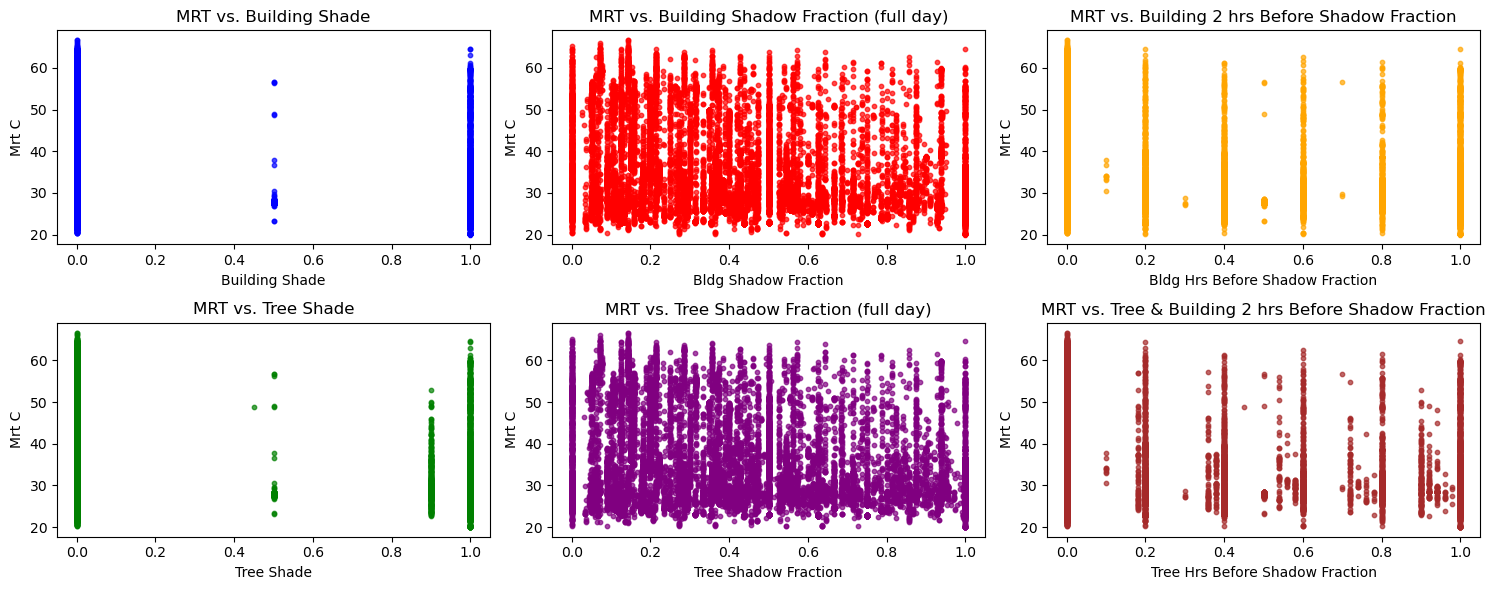

In [13]:
# Define a color list for different scatter plots
color_list = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns

# Scatter plots with colors, labels, and axis names
scatter_plots = [
    (0, 0, 'building_shade', 'MRT_C', 'MRT vs. Building Shade'),
    (1, 0, 'tree_shade', 'MRT_C', 'MRT vs. Tree Shade'),
    (0, 1, 'bldg_shadow_fraction', 'MRT_C', 'MRT vs. Building Shadow Fraction (full day)'),
    (1, 1, 'tree_shadow_fraction', 'MRT_C', 'MRT vs. Tree Shadow Fraction (full day)'),
    (0, 2, 'bldg_hrs_before_shadow_fraction', 'MRT_C', 'MRT vs. Building 2 hrs Before Shadow Fraction'),
    (1, 2, 'tree_hrs_before_shadow_fraction', 'MRT_C', 'MRT vs. Tree & Building 2 hrs Before Shadow Fraction')
]

# Iterate over axes and plot
for i, (x, y, x_col, y_col, title) in enumerate(scatter_plots):
    row, col = x, y  # Get subplot row and column index
    ax = axes[row, col]

    # Scatter plot with colors and smaller points
    ax.scatter(df_shade_MRT[x_col], df_shade_MRT[y_col], s=10, c=color_list[i], alpha=0.7)

    # Set title and axis labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_col.replace("_", " ").title(), fontsize=10)
    ax.set_ylabel(y_col.replace("_", " ").title(), fontsize=10)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

#### Correlation Analysis

Add columns with different binning

In [14]:
df.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right',
       'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back'],
      dtype='object')

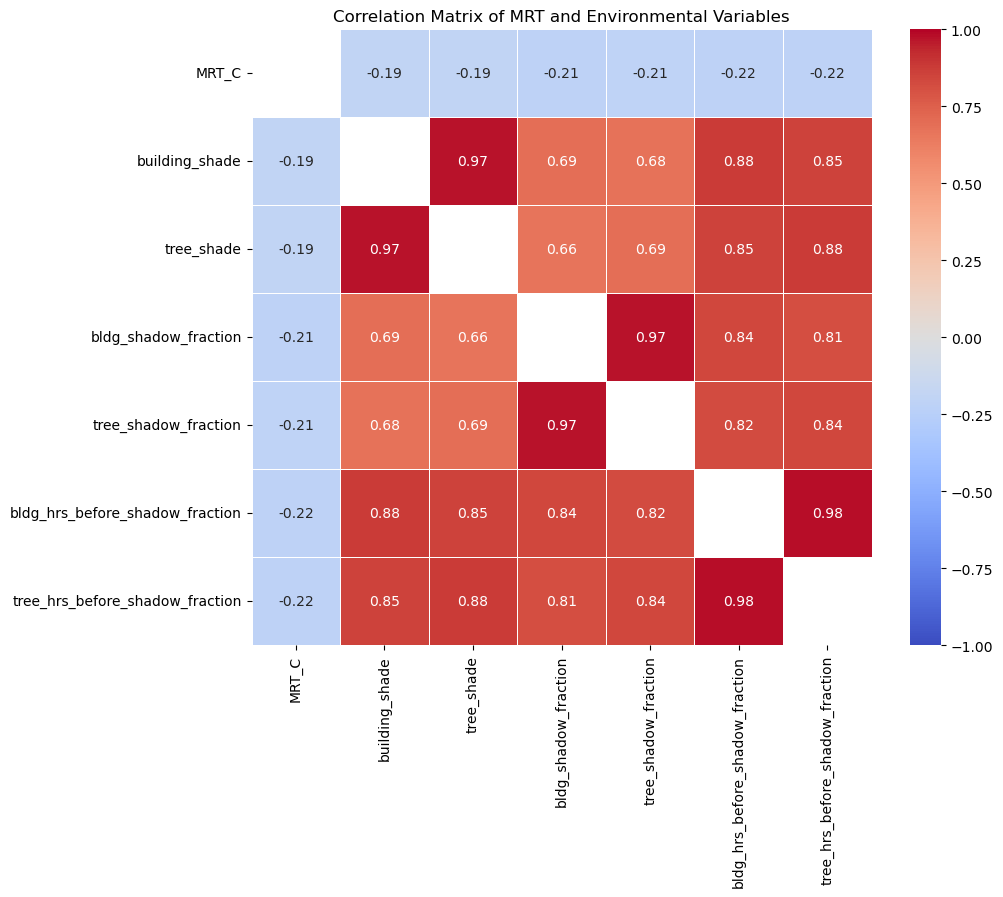

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

columns_of_interest = ['MRT_C', 'building_shade', 'tree_shade', 'bldg_shadow_fraction',
                       'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction']

# columns_of_interest = ['MRT_C', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction', 'Air_Temp', 'humidity', 'WS_ms']

# Compute correlation matrix
correlation_matrix = df_shade_MRT[columns_of_interest].corr()

# Mask the diagonal
mask = np.eye(len(correlation_matrix), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Matrix of MRT and Environmental Variables")
plt.show()

In [16]:
df_shade_MRT['Air_Temp'] = df_shade_MRT['Air_Temp'].astype('float64')
df_shade_MRT['humidity'] = df_shade_MRT['humidity'].astype('float64')
df_shade_MRT['WS_ms'] = df_shade_MRT['WS_ms'].astype('float64')

In [17]:
df_shade_MRT.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction',
       'tree_hrs_before_shadow_fraction', 'geometry', 'E_in', 'E_out',
       'E_left', 'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C',
       'E_long_in', 'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out',
       'E_total_out', 'E_long_left', 'E_short_left', 'E_total_left',
       'E_long_right', 'E_short_right', 'E_total_right', 'E_long_front',
       'E_short_front', 'E_total_front', 'E_long_back', 'E_short_back',
       'E_total_back'],
      dtype='object')

In [18]:
directions = ['in', 'out', 'left', 'right', 'front', 'back']

In [19]:
df_shade_MRT['E_short_avg'] = df_shade_MRT[['E_short_' + d for d in directions]].mean(axis=1)
df_shade_MRT['E_long_avg'] = df_shade_MRT[['E_long_' + d for d in directions]].mean(axis=1)

In [20]:
df_shade_MRT['TIMESTAMP'].dtype

dtype('O')

In [21]:
df_shade_MRT['TIMESTAMP'] = pd.to_datetime(df_shade_MRT['TIMESTAMP'])

In [22]:
df_shade_MRT['TIMESTAMP'].dt.month

0        8
1        8
2        8
3        8
4        8
        ..
33900    9
33901    9
33902    9
33903    9
33904    9
Name: TIMESTAMP, Length: 33905, dtype: int32

In [23]:
df_shade_MRT_aug = df_shade_MRT[df_shade_MRT['TIMESTAMP'].dt.month == 8]

In [24]:
df_shade_MRT_aug.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction',
       'tree_hrs_before_shadow_fraction', 'geometry', 'E_in', 'E_out',
       'E_left', 'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C',
       'E_long_in', 'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out',
       'E_total_out', 'E_long_left', 'E_short_left', 'E_total_left',
       'E_long_right', 'E_short_right', 'E_total_right', 'E_long_front',
       'E_short_front', 'E_total_front', 'E_long_back', 'E_short_back',
       'E_total_back', 'E_short_avg', 'E_long_avg'],


In [25]:
df_shade_MRT_aug['TIMESTAMP'].unique()

<DatetimeArray>
['2023-08-23 12:57:00', '2023-08-23 12:58:00', '2023-08-23 12:59:00',
 '2023-08-23 13:00:00', '2023-08-23 13:01:00', '2023-08-23 13:02:00',
 '2023-08-23 13:03:00', '2023-08-23 13:04:00', '2023-08-23 13:05:00',
 '2023-08-23 13:06:00',
 ...
 '2023-08-23 16:23:00', '2023-08-23 16:24:00', '2023-08-23 16:25:00',
 '2023-08-23 16:26:00', '2023-08-23 16:27:00', '2023-08-23 16:28:00',
 '2023-08-23 16:29:00', '2023-08-23 16:30:00', '2023-08-23 16:31:00',
 '2023-08-23 16:32:00']
Length: 216, dtype: datetime64[ns]

There are 1936 points in this interval: 2023-08-23 12:55:00 - 2023-08-23 13:30:00
There are 1800 points in this interval: 2023-08-23 13:30:00 - 2023-08-23 14:00:00
There are 1795 points in this interval: 2023-08-23 14:00:00 - 2023-08-23 14:30:00
There are 1794 points in this interval: 2023-08-23 14:30:00 - 2023-08-23 15:00:00
There are 1800 points in this interval: 2023-08-23 15:00:00 - 2023-08-23 15:30:00
There are 1800 points in this interval: 2023-08-23 15:30:00 - 2023-08-23 16:00:00
There are 1787 points in this interval: 2023-08-23 16:00:00 - 2023-08-23 16:30:00


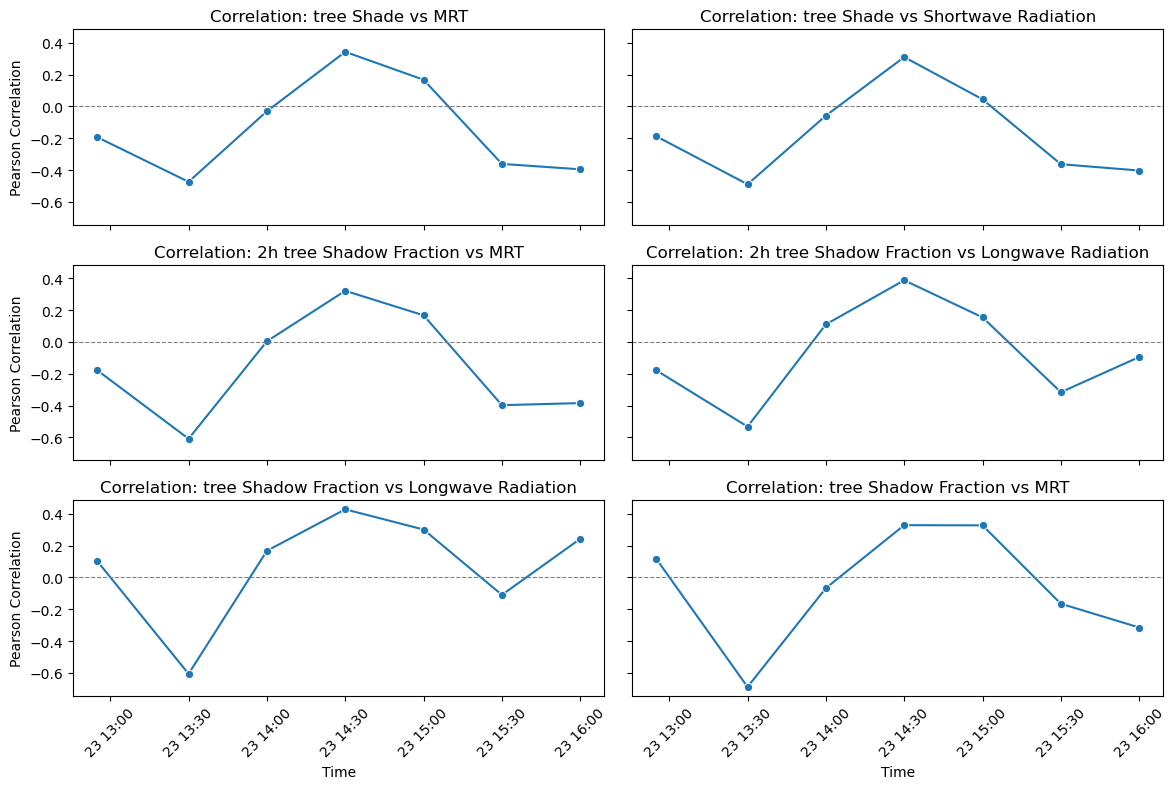

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the time intervals
august_intervals = [
    ('2023-08-23 12:55:00', '2023-08-23 13:30:00'),
    ('2023-08-23 13:30:00', '2023-08-23 14:00:00'),
    ('2023-08-23 14:00:00', '2023-08-23 14:30:00'),
    ('2023-08-23 14:30:00', '2023-08-23 15:00:00'),
    ('2023-08-23 15:00:00', '2023-08-23 15:30:00'),
    ('2023-08-23 15:30:00', '2023-08-23 16:00:00'),
    ('2023-08-23 16:00:00', '2023-08-23 16:30:00')
]

# Convert the intervals to datetime
august_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in august_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_avg", "tree Shade", "Shortwave Radiation"),
    ("tree_hrs_before_shadow_fraction", "MRT_C", "2h tree Shadow Fraction", "MRT"),
    ("tree_hrs_before_shadow_fraction", "E_long_avg", "2h tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "E_long_avg", "tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "MRT_C", "tree Shadow Fraction", "MRT")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in august_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_aug[
        (df_shade_MRT_aug['TIMESTAMP'] >= start) &
        (df_shade_MRT_aug['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
df_shade_MRT_aug.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction',
       'tree_hrs_before_shadow_fraction', 'geometry', 'E_in', 'E_out',
       'E_left', 'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C',
       'E_long_in', 'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out',
       'E_total_out', 'E_long_left', 'E_short_left', 'E_total_left',
       'E_long_right', 'E_short_right', 'E_total_right', 'E_long_front',
       'E_short_front', 'E_total_front', 'E_long_back', 'E_short_back',
       'E_total_back', 'E_short_avg', 'E_long_avg'],


In [28]:
df_shade_MRT_aug[df_shade_MRT_aug['building_shade'] == 1][['building_shade', 'tree_shade']]

,building_shade,tree_shade
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
12579,1.0,1.0
12580,1.0,1.0
12595,1.0,1.0
12596,1.0,1.0


In [29]:
df_shade_MRT_aug

,TIMESTAMP,RECORD,GPSData,Air_Temp,humidity,Qs_in,Qs_out,Qs_left,Qs_right,Qs_front,...,E_short_right,E_total_right,E_long_front,E_short_front,E_total_front,E_long_back,E_short_back,E_total_back,E_short_avg,E_long_avg
0,2023-08-23 12:57:00,56706,230823115735N5222666E00452996G004-00018E0000N0...,25.33,48.43,38.7,2.243,14.95,8.24,19.76,...,5.768,453.267629,440.492629,13.832,454.324629,438.522629,11.683,450.205629,11.734683,439.769796
1,2023-08-23 12:57:00,56707,230823115736N5222666E00452996G004-00018E0000N0...,25.29,48.43,38.7,2.243,15.17,8.24,19.76,...,5.768,453.141438,440.251438,13.832,454.083438,440.691438,10.948,451.639438,11.637850,439.949438
2,2023-08-23 12:57:00,56708,230823115737N5222666E00452996G004-00018E0000N0...,25.29,48.46,38.7,2.243,15.17,8.24,19.76,...,5.768,453.141438,440.251438,13.832,454.083438,443.369438,9.345,452.714438,11.370683,440.414105
3,2023-08-23 12:57:00,56709,230823115738N5222666E00452996G004-00018E0000N0...,25.22,48.45,38.92,2.243,15.17,8.24,19.76,...,5.768,452.719587,439.829587,13.832,453.661587,441.877587,10.367,452.244587,11.566683,439.813920
4,2023-08-23 12:57:00,56710,230823115739N5222666E00452996G004-00018E0000N0...,25.13,48.38,38.92,2.243,15.17,8.24,19.76,...,5.768,452.293643,439.287643,13.832,453.119643,440.667643,10.808,451.475643,11.640183,439.198309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12852,2023-08-23 16:32:00,69582,230823153211N5223747E00457513G004-00004E0000N0...,22.94,54.84,377.5,42.62,55.61,781.5,35.24,...,547.050,985.488761,437.102761,24.668,461.770761,427.490761,139.720,567.210761,174.074833,432.774261
12853,2023-08-23 16:32:00,69583,230823153212N5223747E00457513G004-00004E0000N0...,22.97,54.94,376.8,41.72,55.17,733.6,35.65,...,513.520,952.595406,437.041406,24.955,461.996406,427.667406,139.580,567.247406,168.273000,432.934573
12854,2023-08-23 16:32:00,69584,230823153213N5223747E00457513G004-00004E0000N0...,23.00,55.07,380.4,41.95,54.95,748.6,35.85,...,524.020,962.812105,437.218105,25.095,462.313105,428.114105,139.580,567.694105,170.467500,433.132938
12855,2023-08-23 16:32:00,69585,230823153214N5223747E00457513G004-00004E0000N0...,22.99,55.19,383,41.95,54.95,759.2,36.06,...,531.440,969.943199,437.397199,25.242,462.639199,428.191199,139.720,567.911199,172.055333,433.169699


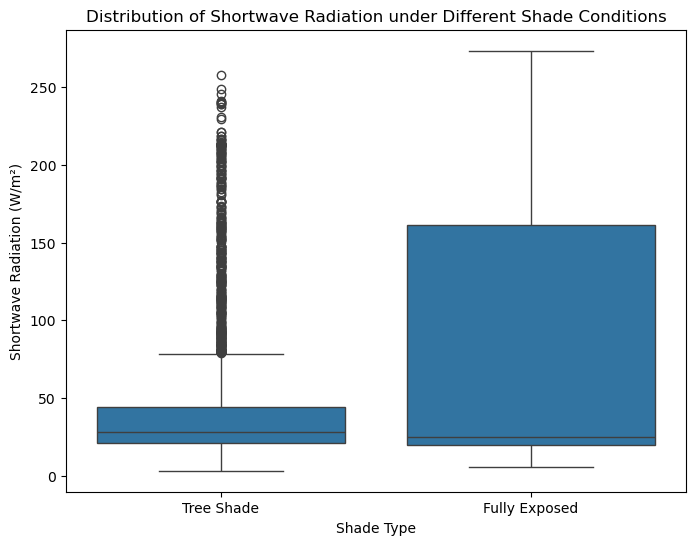

In [30]:
# Define the three filtering conditions
df_building_shade_only = df_shade_MRT_aug[
    (df_shade_MRT_aug['building_shade'] == 1) & (df_shade_MRT_aug['tree_shade'] != 1)
].copy()

df_tree_shade_only = df_shade_MRT_aug[
    (df_shade_MRT_aug['tree_shade'] == 1)
].copy()

df_fully_exposed = df_shade_MRT_aug[
    (df_shade_MRT_aug['tree_shade'] == 0)
].copy()

# Add a column to label each dataset category
df_building_shade_only['Shade Type'] = 'Building Shade'
df_tree_shade_only['Shade Type'] = 'Tree Shade'
df_fully_exposed['Shade Type'] = 'Fully Exposed'

# Combine all datasets
df_combined = pd.concat([df_building_shade_only, df_tree_shade_only, df_fully_exposed])

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Shade Type', y='E_short_avg', data=df_combined)

# Customize plot
plt.title("Distribution of Shortwave Radiation under Different Shade Conditions")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.xlabel("Shade Type")

# Show plot
plt.show()

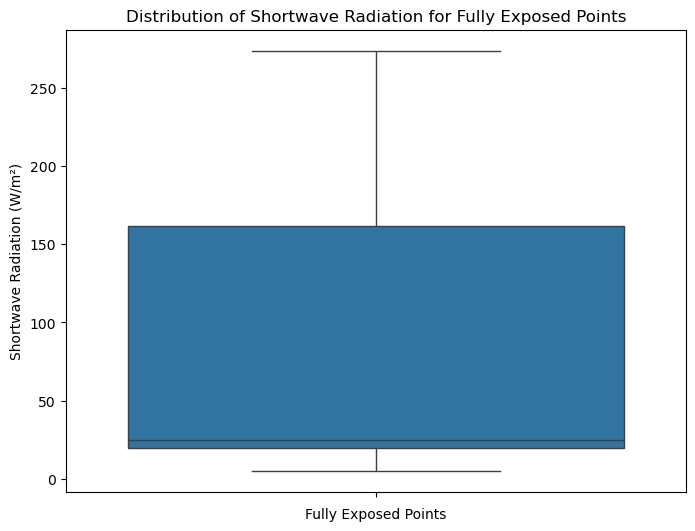

In [31]:
# Filter for fully exposed points (no tree shade, no building shade)
df_no_shaded = df_shade_MRT_aug[
    (df_shade_MRT_aug['tree_shade'] == 0) & (df_shade_MRT_aug['building_shade'] == 0)
]

# Create the box plot directly
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_no_shaded['E_short_avg'])

# Customize the plot
plt.title("Distribution of Shortwave Radiation for Fully Exposed Points")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.xlabel("Fully Exposed Points")

# Show the plot
plt.show()


In [33]:
df_shade_MRT_sept = df_shade_MRT[df_shade_MRT['TIMESTAMP'].dt.month == 9]

In [34]:
df_shade_MRT_sept['TIMESTAMP'].unique()

<DatetimeArray>
['2023-09-12 09:48:00', '2023-09-12 09:49:00', '2023-09-12 09:50:00',
 '2023-09-12 09:51:00', '2023-09-12 09:52:00', '2023-09-12 09:53:00',
 '2023-09-12 09:54:00', '2023-09-12 09:55:00', '2023-09-12 09:56:00',
 '2023-09-12 09:57:00',
 ...
 '2023-09-12 15:30:00', '2023-09-12 15:31:00', '2023-09-12 15:32:00',
 '2023-09-12 15:33:00', '2023-09-12 15:34:00', '2023-09-12 15:35:00',
 '2023-09-12 15:36:00', '2023-09-12 15:37:00', '2023-09-12 15:38:00',
 '2023-09-12 15:39:00']
Length: 352, dtype: datetime64[ns]

There are 708 points in this interval: 2023-09-12 09:30:00 - 2023-09-12 10:00:00
There are 1800 points in this interval: 2023-09-12 10:00:00 - 2023-09-12 10:30:00
There are 1775 points in this interval: 2023-09-12 10:30:00 - 2023-09-12 11:00:00
There are 1800 points in this interval: 2023-09-12 11:30:00 - 2023-09-12 12:00:00
There are 1797 points in this interval: 2023-09-12 12:00:00 - 2023-09-12 12:30:00
There are 1795 points in this interval: 2023-09-12 12:30:00 - 2023-09-12 13:00:00
There are 1800 points in this interval: 2023-09-12 13:00:00 - 2023-09-12 13:30:00
There are 1800 points in this interval: 2023-09-12 13:30:00 - 2023-09-12 14:00:00
There are 1800 points in this interval: 2023-09-12 14:00:00 - 2023-09-12 14:30:00
There are 1800 points in this interval: 2023-09-12 14:30:00 - 2023-09-12 15:00:00
There are 2373 points in this interval: 2023-09-12 15:00:00 - 2023-09-12 15:40:00


c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


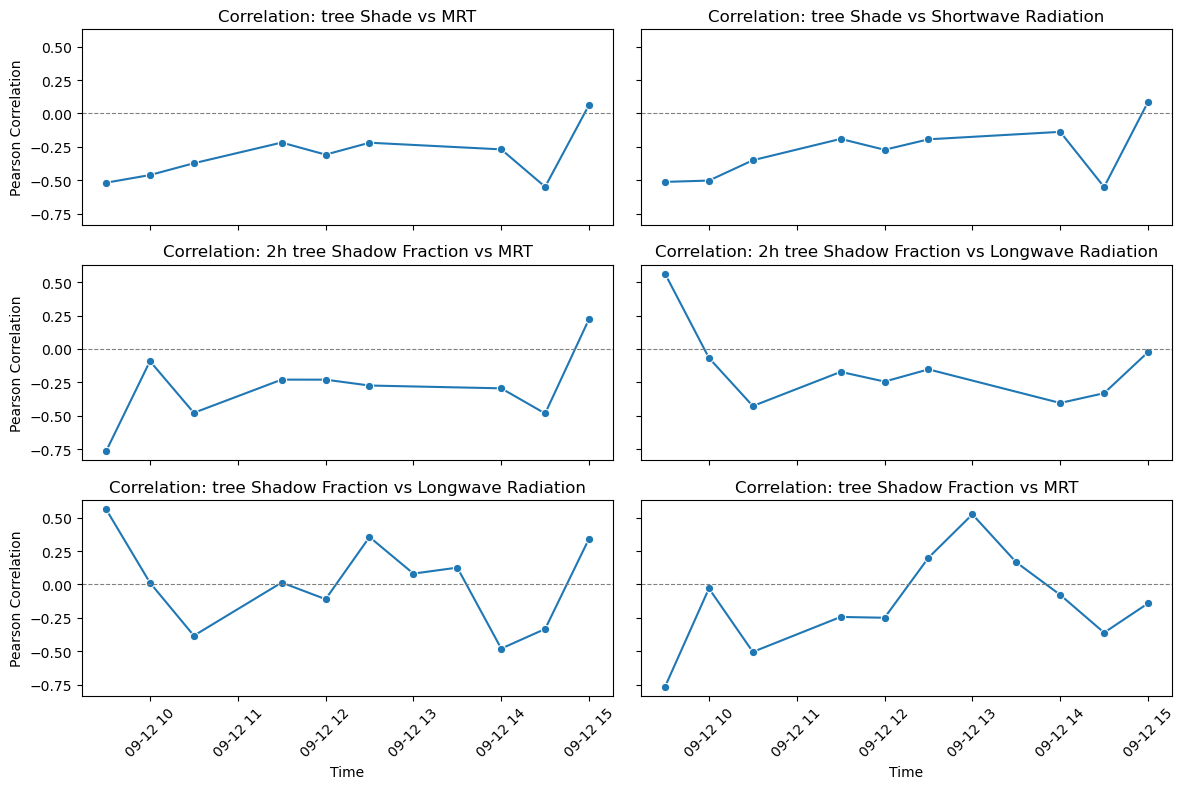

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the time intervals
sept_intervals = [
    ('2023-09-12 09:30:00', '2023-09-12 10:00:00'),
    ('2023-09-12 10:00:00', '2023-09-12 10:30:00'),
    ('2023-09-12 10:30:00', '2023-09-12 11:00:00'),
    ('2023-09-12 11:30:00', '2023-09-12 12:00:00'),
    ('2023-09-12 12:00:00', '2023-09-12 12:30:00'),
    ('2023-09-12 12:30:00', '2023-09-12 13:00:00'),
    ('2023-09-12 13:00:00', '2023-09-12 13:30:00'),
    ('2023-09-12 13:30:00', '2023-09-12 14:00:00'),
    ('2023-09-12 14:00:00', '2023-09-12 14:30:00'),
    ('2023-09-12 14:30:00', '2023-09-12 15:00:00'),
    ('2023-09-12 15:00:00', '2023-09-12 15:40:00')
]

# Convert the intervals to datetime
sept_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in sept_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_avg", "tree Shade", "Shortwave Radiation"),
    ("tree_hrs_before_shadow_fraction", "MRT_C", "2h tree Shadow Fraction", "MRT"),
    ("tree_hrs_before_shadow_fraction", "E_long_avg", "2h tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "E_long_avg", "tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "MRT_C", "tree Shadow Fraction", "MRT")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in sept_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_sept[
        (df_shade_MRT_sept['TIMESTAMP'] >= start) &
        (df_shade_MRT_sept['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

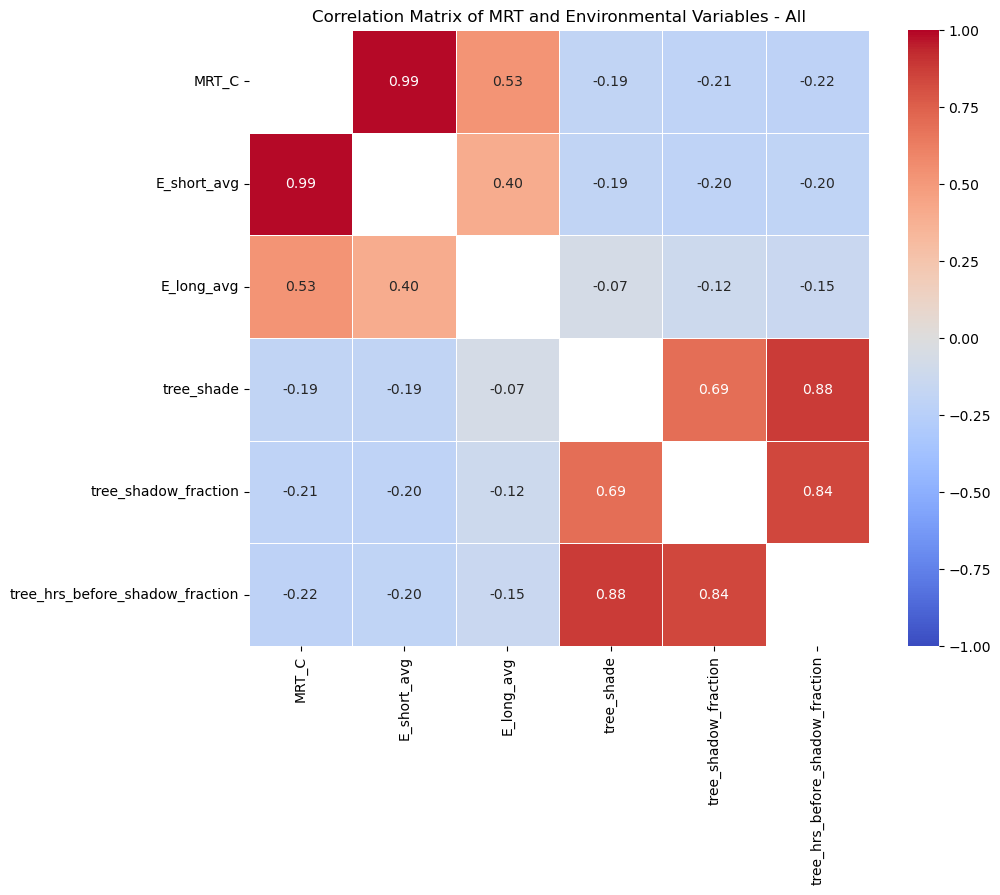

In [36]:
# columns_of_interest = ['MRT_C', 'E_short_avg', 'E_long_avg', 'building_shade', 'tree_shade', 'bldg_shadow_fraction',
#                        'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction']

columns_of_interest = ['MRT_C', 'E_short_avg', 'E_long_avg', 'tree_shade',
                       'tree_shadow_fraction', 'tree_hrs_before_shadow_fraction']

# columns_of_interest = ['MRT_C', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction', 'Air_Temp', 'humidity', 'WS_ms']

# Compute correlation matrix
correlation_matrix = df_shade_MRT[columns_of_interest].corr()

# Mask the diagonal
mask = np.eye(len(correlation_matrix), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Matrix of MRT and Environmental Variables - All")
plt.show()

In [37]:
sun_sensor = pd.read_csv("../data/validation/3k_CY1_Mar_7_2025_3_30_40_PM.csv")
shade_sensor = pd.read_csv("../data/validation/6k_CY1_Mar_7_2025_2_45_00_PM.csv")

#### Clean data

In [93]:
sun_sensor.columns

Index(['FORMATTED DATE_TIME', 'Temperature', 'Wet Bulb Temp',
       'Globe Temperature', 'Relative Humidity', 'Barometric Pressure',
       'Altitude', 'Station Pressure', 'Wind Speed', 'Heat Index', 'Dew Point',
       'Density Altitude', 'Crosswind', 'Headwind',
       'Compass Magnetic Direction', 'NWB Temp', 'Compass True Direction',
       'Thermal Work Limit', 'Wet Bulb Globe Temperature', 'Wind Chill',
       'Data Type', 'Record name', 'Start time', 'Duration (H:M:S)'],
      dtype='object')

In [49]:
sun_sensor = sun_sensor.drop(['Location description','Location address','Location coordinates','Notes'], axis=1)
shade_sensor = shade_sensor.drop(['Location description','Location address','Location coordinates','Notes'], axis=1)

In [64]:
sun_sensor = sun_sensor.iloc[1:]
shade_sensor = shade_sensor.iloc[1:]

In [95]:
for col in ['Temperature', 'Wet Bulb Temp', 'Globe Temperature', 'Relative Humidity','Wind Speed', 'Heat Index']:
    # Convert Globe Temperature to float
    sun_sensor[col] = pd.to_numeric(sun_sensor[col], errors='coerce')
    shade_sensor[col] = pd.to_numeric(shade_sensor[col], errors='coerce')

C:\Users\Dila Ozberkman\AppData\Local\Temp\ipykernel_6468\3733666483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shade_sensor[col] = pd.to_numeric(shade_sensor[col], errors='coerce')


In [67]:
sun_sensor['FORMATTED DATE_TIME'] = pd.to_datetime(sun_sensor['FORMATTED DATE_TIME'])
shade_sensor['FORMATTED DATE_TIME'] = pd.to_datetime(shade_sensor['FORMATTED DATE_TIME'])

C:\Users\Dila Ozberkman\AppData\Local\Temp\ipykernel_6468\608783625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shade_sensor['FORMATTED DATE_TIME'] = pd.to_datetime(shade_sensor['FORMATTED DATE_TIME'])


#### Filter to the right timeframe

In [96]:
sun_sensor_0307 = sun_sensor[sun_sensor['FORMATTED DATE_TIME'].dt.month == 3]
shade_sensor_0307 = shade_sensor[shade_sensor['FORMATTED DATE_TIME'].dt.month == 3]

In [97]:
sun_max = max(sun_sensor_0307['FORMATTED DATE_TIME'])
sun_min = min(sun_sensor_0307['FORMATTED DATE_TIME'])
shade_max = max(shade_sensor_0307['FORMATTED DATE_TIME'])
shade_min = min(shade_sensor_0307['FORMATTED DATE_TIME'])
print(f"Sun data range {sun_min} - {sun_max}")
print(f"Shade data range {shade_min} - {shade_max}")

Sun data range 2025-03-07 11:42:00 - 2025-03-07 15:30:00
Shade data range 2025-03-07 14:01:00 - 2025-03-07 14:45:00


In [98]:
sun_data_range = sun_sensor_0307[(sun_sensor_0307['FORMATTED DATE_TIME'] >= pd.to_datetime('2025-03-07 14:10:00')) &
                            (sun_sensor_0307['FORMATTED DATE_TIME'] <= pd.to_datetime('2025-03-07 14:40:00'))]

shade_data_range = shade_sensor_0307[(shade_sensor_0307['FORMATTED DATE_TIME'] >= pd.to_datetime('2025-03-07 14:10:00')) &
                            (shade_sensor_0307['FORMATTED DATE_TIME'] <= pd.to_datetime('2025-03-07 14:40:00'))]

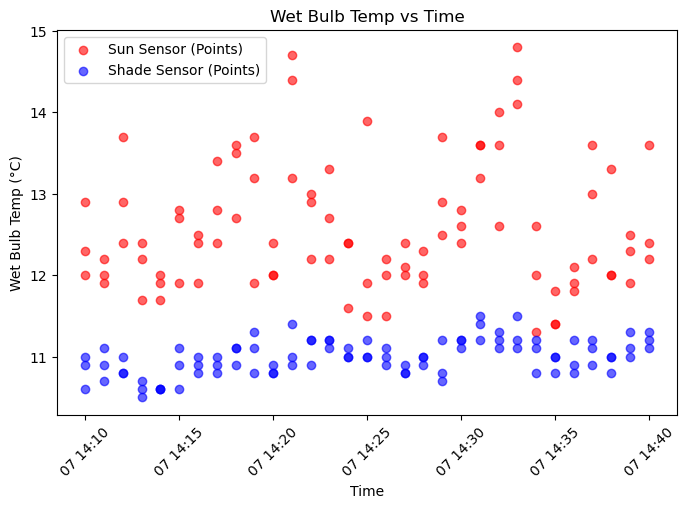

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract time and Globe Temperature values
sun_time = sun_data_range['FORMATTED DATE_TIME']
sun_temp = sun_data_range['Wet Bulb Temp']

shade_time = shade_data_range['FORMATTED DATE_TIME']
shade_temp = shade_data_range['Wet Bulb Temp']

# Plot
plt.figure(figsize=(8, 5))

# Scatter plot for actual data points
plt.scatter(sun_time, sun_temp, color='red', label='Sun Sensor (Points)', alpha=0.6)
plt.scatter(shade_time, shade_temp, color='blue', label='Shade Sensor (Points)', alpha=0.6)

# Formatting
plt.xlabel("Time")
plt.ylabel("Wet Bulb Temp (°C)")
plt.title("Wet Bulb Temp vs Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [58]:
sun_sensor.head(5)

,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Globe Temperature,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,...,Compass Magnetic Direction,NWB Temp,Compass True Direction,Thermal Work Limit,Wet Bulb Globe Temperature,Wind Chill,Data Type,Record name,Start time,Duration (H:M:S)
0,yyyy-MM-dd hh:mm:ss a,°C,°C,°C,%,mb,m,mb,km/h,°C,...,Deg,°C,Deg,w/m2,°C,°C,NaN,NaN,NaN,NaN
1,8/27/2024 8:24,22.4,17.1,22.1,58.5,1023.7,-89,1023.8,0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
2,8/27/2024 8:24,22.4,17.1,22.1,58.7,1023.5,-86,1023.5,0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
3,8/27/2024 8:24,22.4,17.1,22.1,58.8,1023.5,-86,1023.5,0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
4,8/27/2024 8:24,22.4,17.1,22.1,58.9,1024.6,-97,1024.7,0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN


In [57]:
sun_sensor['Record name']

0                                      NaN
1                                      NaN
2                                      NaN
3                                      NaN
4                                      NaN
                       ...                
10545    Session - Mar 7, 2025 11:57:47 AM
10546    Session - Mar 7, 2025 11:57:47 AM
10547    Session - Mar 7, 2025 11:57:47 AM
10548    Session - Mar 7, 2025 11:57:47 AM
10549    Session - Mar 7, 2025 11:57:47 AM
Name: Record name, Length: 10550, dtype: object

In [41]:
shade_sensor['Globe Temperature'].values

array(['°C', '18.6', '18.6', '18.6', '18.6', '18.5', '18.5', '18.5',
       '18.5', '18.4', '18.4', '18.4', '18.4', '18.4', '18.4', '18.4',
       '18.4', '18.4', '18.5', '18.5', '18.5', '18.5', '18.5', '18.4',
       '18.4', '18.4', '18.4', '18.4', '18.5', '18.6', '18.6', '18.7',
       '18.7', '18.7', '18.7', '18.7', '18.7', '18.8', '18.8', '18.8',
       '18.8', '18.8', '18.8', '18.8', '18.8', '18.8', '18.8', '18.7',
       '18.7', '18.7', '18.7', '18.7', '18.7', '18.6', '18.6', '18.6',
       '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5',
       '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.4',
       '18.4', '18.4', '18.4', '18.5', '18.5', '18.5', '18.5', '18.5',
       '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5',
       '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5', '18.5',
       '18.5', '18.5', '18.5', '18.5', '18.5', '18.4', '18.4', '18.4',
       '18.6', '18.7', '18.6', '18.6', '18.6', '18.6', '18.6', '18.7',
       '